C:\Users\Krishna\AppData\Local\Temp\ipykernel_13440\1874917673.py:48: RuntimeWarning: invalid value encountered in scalar divide
  H[idx, 0] = delta_x / distance
C:\Users\Krishna\AppData\Local\Temp\ipykernel_13440\1874917673.py:49: RuntimeWarning: invalid value encountered in scalar divide
  H[idx, 2] = delta_y / distance
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite

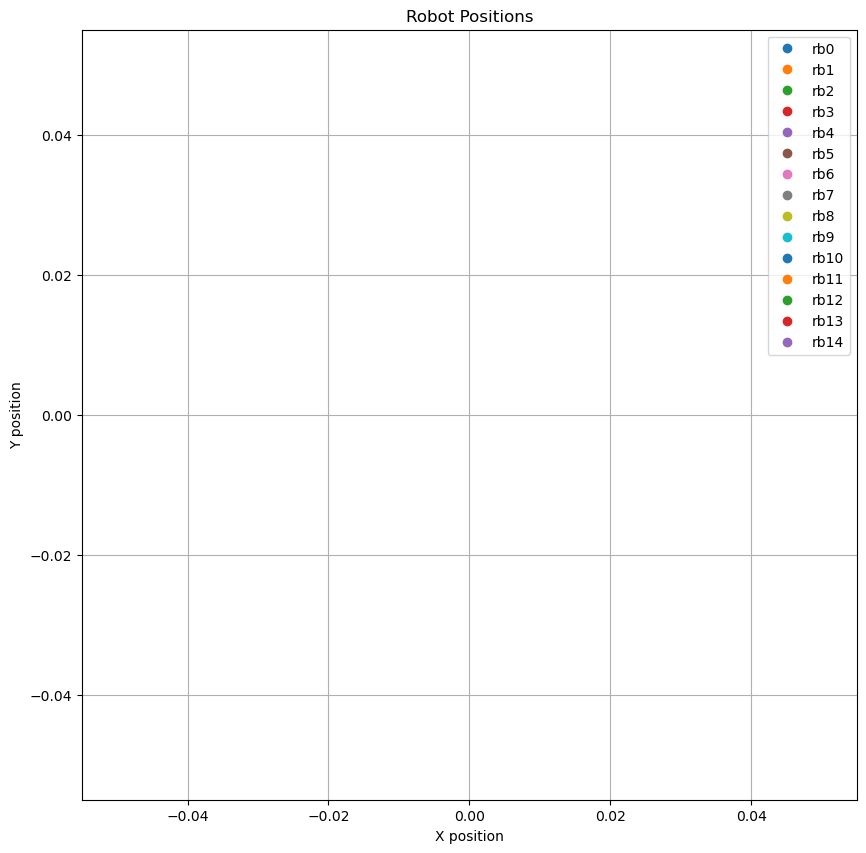

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Robot:
    def __init__(self, id, x, y, std_dev):
        self.id = id
        self.x = x
        self.y = y
        self.state = np.array([[x], [0], [y], [0]])  # Initial state [x_pos, x_vel, y_pos, y_vel]
        self.P = np.eye(4) * 1000  # Initial covariance large to represent high uncertainty
        self.std_dev = std_dev  # Standard deviation for the process noise

    def predict(self, F, Q):
        self.state = F @ self.state
        self.P = F @ self.P @ F.T + Q

    def update(self, Z, H, R):
        Y = Z - H @ self.state
        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.state = self.state + K @ Y
        self.P = self.P - K @ H @ self.P

    def get_distance(self, other_robot):
        dx = other_robot.x - self.x
        dy = other_robot.y - self.y
        return np.sqrt(dx**2 + dy**2)

class Environment:
    def __init__(self, num_robots, std_dev):
        self.robots = [Robot(i, np.random.uniform(0, 10), np.random.uniform(0, 10), std_dev) for i in range(num_robots)]

    def simulate(self, steps, dt):
        F = np.array([[1, dt, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, dt],
                      [0, 0, 0, 1]])  # State transition model

        for step in range(steps):
            Q = np.eye(4) * self.robots[0].std_dev ** 2  # Process noise covariance
            for robot in self.robots:
                robot.predict(F, Q)

            for robot in self.robots:
                Z = np.array([[robot.get_distance(other)] for other in self.robots if other != robot])
                H = np.zeros((len(Z), 4))  # Measurement matrix
                R = np.eye(len(Z)) * robot.std_dev ** 2  # Measurement noise covariance

                for idx, other in enumerate(self.robots):
                    if other == robot:
                        continue
                    dx = other.x - robot.x
                    dy = other.y - robot.y
                    distance = robot.get_distance(other)
                    if distance == 0:
                        continue
                    H[idx, 0] = dx / distance
                    H[idx, 2] = dy / distance

                robot.update(Z, H, R)

            # Plotting the positions after each step
            self.plot_positions(step)

    def plot_positions(self, step):
        plt.figure(figsize=(10, 8))
        for robot in self.robots:
            plt.scatter(robot.x, robot.y, label=f'Robot {robot.id} True')
            plt.scatter(robot.state[0], robot.state[2], label=f'Robot {robot.id} EKF')

        plt.title(f'Robot Positions at Step {step}')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.legend()
        plt.grid(True)
        plt.show()

# Running the simulation with plotting
num_robots = 10
std_dev = 0.1
env = Environment(num_robots, std_dev)
env.simulate(1, 1)  # We will simulate one step at a time to visualize the EKF update
